# abalone 회귀분석

**신경망 직접 짜기**

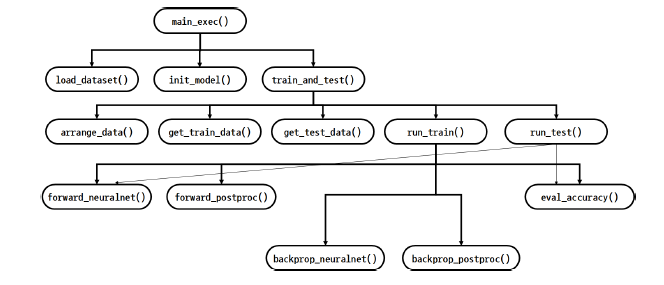

In [92]:
import pandas as pd
import numpy as np
import csv

df = pd.read_csv('/content/abalone.csv')

In [93]:
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [94]:
np.random.seed(1111)
#신경망 학습하는데 사용하는 하이퍼파라미터
RND_MEAN=0
RND_STD=0.0030
LEARNING_RATE=0.001

처음에는 무작위 값을 지정해 줄 수 밖에 없다. -> 그래도 최소한의 규칙성 있는 범위 내에서 '난수'를 지정하고 싶다면 Xavier 초기화 He 초기화가 가장 많이 쓰인다.

In [95]:
def main_exec(epoch_count=10, mb_size=10, report=1, train_rate=0.7):
  load_dataset() #데이터를 불러오는 기능
  init_model()   #파라미터를 초기화하는 기능
  train_and_test(epoch_count,mb_size,report,train_rate) #학습 및 신경망 성능 테스트

In [96]:
#데이터를 불러오고, 원-핫 벡터 처리
def load_dataset():
  #csvfile로 이름 짓기
  with open('/content/abalone.csv') as csvfile:
    csvreader = csv.reader(csvfile) #csvfile이라는 파일을 읽어 올 것이다.
    next(csvreader, None) # 하나를 건너뛴 결과(None으로 첫번째 값(변수명이므로)을 쓰지 않겠다!) -> next를 저장하면 출력하면 하나를 건너 뛴 상태로 나온다.
    rows = []
    for row in csvreader:
      rows.append(row)#반복문을 통해 데이터를 list에 저장
  
  #전역변수
  global data, input_cnt, output_cnt
  
  #변수 몇 개인가? -> 원핫 인코딩으로 인한 10개
  #출력하고자하는 값의 크기 = output_cnt(하나의 퍼셉트론)
  input_cnt, output_cnt = 10, 1 # 독립변수의 크기와 종속변수의 크기

  #버퍼 
  data = np.zeros([len(rows),input_cnt+output_cnt]) #zero는 넣은 값의 크기만큼 버퍼의 크기를 만든다.
  #print(data)
  #print(data.shape)

  #원 - 핫 벡터 처리
  #index와 row 두개를 얻기 위해서 enumerate사용
  for n,row in enumerate(rows):
    if row[0] == 'I':
       data[n,0]=1
    if row[0] == 'M':
       data[n,1]=1
    if row[0] == 'F':
       data[n,2]=1
    data[n,3:]=row[1:]
  print(data)


In [97]:
#두 번째 기능 구축하기 - 파라미터 초기화(편향과 가중치)
def init_model():
  global weight, bias, input_cnt, output_cnt #가중치 / 편향 / input_cnt / output_cnt
  #normal()를 활용하여 가중치에 대한 초기 무작위 값을 설정 -> local minimum을 피하고자 했다.
  #크기[10,1]
  weight=np.random.normal(RND_MEAN,RND_STD,[input_cnt,output_cnt])
  #zeros()를 활용하여 편향에 대한 초기 무작위 값을 설정 (크기[1])
  bias = np.zeros([output_cnt])


In [98]:
#세 번째 기능 구축하기 - 학습과 테스트를 관장하는 가능 / 학습에 대한 결과 표시
def train_and_test(epoch_count, mb_size, report, train_rate):
  # 반환하는 값은 미니배치가 몇 덩어리(스텝)으로 쪼개지는지
  # 1 epoch 당 mb_size수를 계산하여 step_count에 저장
  step_count = arrange_data(mb_size, train_rate)
  # 테스트 데이터에 대한 독립변수와 종속변수를 얻어냅니다.(테스트에 사용할 데이터 만큼 분리함)
  test_x, test_y = get_test_data()

  #2중 반복문
  #에폭이 돌아가는 첫 번째 반복문
  for epoch in range(epoch_count):
    # 전체 미니배치(1에폭당)의 결과인 손실과 정확도를 받는 빈 리스트 정의
    losses, accs = [], []  

    # 한번의 에폭이 돌아가는 동안의 미니배치 스탭카운트 반복 수행
    for n in range(step_count):
      # 미니배치 사이즈와 스탭카운트의 개별값을 받아 학습데이터의 독립, 종속변수 반환
      # train_x와 train_y를 전달 -> 훈련 데이터 나눠서 가져오기
      train_x, train_y = get_train_data(mb_size, n) 
      #학습을 수행하는 run_train()는 학습 데이터를 받아 학습데이터에 따른 손실과 정확도를 반환
      loss, acc = run_train(train_x, train_y)
      #미니배치 단위로 수행된 학습 결과 loss와 acc 저장
      losses.append(loss)
      accs.append(acc)
    
    #(report)입력한 주기만큼 결과 확인
    if report>0 and (epoch+1)%report==0:
      acc=run_test(test_x, test_y)
      print("Epoch {} : Train - loss = {:5.3f}, accuracy={:5.3f} / Test = {:5.3f}".format(epoch+1,np.mean(losses),np.mean(accs),acc))

  final_acc = run_test(test_x,test_y)
  print("\n 최종 테스트 결과 : final accuracy = {:5.3f}".format(final_acc))    


In [99]:
#데이터를 섞어주는 기능 -> 미니배치 단위 출력
def arrange_data(mb_size, train_rate):
  #원-핫 인코딩 된 데이터, 무작위로 섞인 shuffle_map, 학습 데이터와 테스트 데이터의 경계선
  global data, shuffle_map, test_begin_index
  #첫 번째 속성값을 np.arange()로 받아 shuffle_map으로 저장
  #np.arange로 data 크기를 0~data 크기의 list로 받음
  shuffle_map=np.arange(data.shape[0])
  #데이터를 무작위 셔플
  np.random.shuffle(shuffle_map)

  #미니배치 스텝 카운트를 구하는 과정
  #mb_size로 나눠서 나오는 나머지는 어떻게 할 껀인가 -> 안 쓴다
  step_count=int(data.shape[0]*train_rate) // mb_size

  #경계선을 탐색하는 코드
  #학습 데이터와 test데이터의 중간 경계선
  test_begin_index = step_count*mb_size

  return step_count

In [100]:
#학습 데이터 분할 과정 기능 구축( 변수 구분 포함 )
def get_train_data(mb_size,n):
  global data, shuffle_map, test_begin_index, output_cnt
  if n==0:
    #1epoch가 수행될 때 첫 번째 미니배치 단위로서, epoch이 순차적으로 수행될 때마다 가장 처음에 수행(매 epoch마다 다르게 train하기 위해)
    np.random.shuffle(shuffle_map[:test_begin_index])
  train_data=data[shuffle_map[mb_size*n : mb_size*(n+1)]] 
  #이렇게 매번 에폭이 늘어날 때마다 학습 데이터를 섞어주게 되면 학습에 대한 효율성이 증가하여 긍정적인 영향을 미친다.
  #train data의 독립변수 반환, 종속변수 반환
  return train_data[:,:-output_cnt], train_data[:,-output_cnt:]

# 테스트 데이터 분할 과정 기능 구축( 변수 구분 포함 )
def get_test_data():
  global data, shuffle_map, test_begin_index, output_cnt
  #test_begin_index 중간 경계선으로부터 끝까지의 data 가져오기
  test_data=data[shuffle_map[test_begin_index:]]
  #test data의 독립변수와 종속변수
  return test_data[:,:-output_cnt], test_data[:,-output_cnt:]

In [101]:
#신경망의 순전파 연산 과정
def forward_neuralnet(x):
  #x는 train_x
  global weight, bias
  output = np.matmul(x,weight)+bias
  # 두 번째 반환값은 x는 aux_nn으로 반환처리되며, 역전파를 수행할 때 사용할 예정
  return output, x

In [102]:
#신경망의 순전파에 따른 mse를 도출하는 과정
def forward_postproc(output, y):
  #편차 -> 제곱 -> 평균(손실)
  diff=output-y

  square=np.square(diff)
  loss=np.mean(square)
  
  #두 번째 변수는 편차로 반환하는 이유는 역전파를 수행하는데 있어 필요하기 때문(aux_pp)
  return loss, diff

In [103]:
#신경망(회귀)의 평가지표를 산출하는 공식(정확도)
#오류율을 연산하는 수식
def eval_accuracy(output,y):
  mdiff=np.mean(np.abs((output-y)/y))
  return 1-mdiff

In [104]:
#mse에 대한 역전파 과정을 수식으로 재현한 코드
#경사하강법에서 학습률과 곱해지는 부분에 대한 결과
def backprop_postproc(G_loss, diff):
  #손실은 [미니배치 크기, 출력벡터 크기]
  shape=diff.shape
  #np.prod()로 한 list 안의 요소 곱하기
  #np.ones()로 모두 1로 만들기
  g_loss_square=np.ones(shape)/np.prod(shape)
  g_square_diff = diff*2
  g_diff_output=1.0
  #θdiff/θoutput을 구하는 과정입니다. 이 또한 결국 1

  G_square = g_loss_square * G_loss
  G_diff = g_square_diff * G_square
  G_output = g_diff_output * G_diff

  return G_output
  # G_output(θL/θoutput)

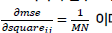

-> g_loss_square

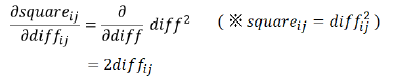

-> g_square_diff

In [105]:
#실질적인 파라미터 갱신이 이뤄지는 함수입니다.
def backprop_neuralnet(G_output, x):
  global weight, bias
  #G_w(θL/θW)를 구하기 위해서는 결과적으로 X^T * G 를 연산
  g_output_w=x.transpose()
  #가중치 갱신을 위한 (θY/θW * θL/θY) 를 구하는 과정
  G_w=np.matmul(g_output_w,G_output)
  #행에 따른 합
  G_b=np.sum(G_output,axis=0)

  weight-=LEARNING_RATE*G_w #weight 갱신
  bias-=LEARNING_RATE*G_b #bias 갱신

In [106]:
def run_train(x,y):
  #aux_nn을 그대로 들고 온 이유는 역전파에 사용하기 위해서
  
  #f_θ(x) = θ_0 + θ_0*x 가 수행되는 함수
  output, aux_nn =forward_neuralnet(x) #일반적인 신경망의 연산
  loss, aux_pp = forward_postproc(output,y) #신경망 연산에 따른 손실함수 계산 과정(mse)
  accuracy = eval_accuracy(output,y) #학습의 1단계(순전파 및 학습 과정)

  G_loss=1.0
  #역전파를 수행하는 과정은 합성함수의 편미분 과정
  #경사하강법에서 학습률과 곱해지는 부분에 대한 결과를 반환
  G_output=backprop_postproc(G_loss,aux_pp)
  #θ를 갱신하는 메서드, 파라미터 갱신
  backprop_neuralnet(G_output, aux_nn)
  return loss, accuracy

In [107]:
#학습의 2단계

#평가를 수행하는 함수 구축 / 정확도 반환
def run_test(x,y):
  #예측값을 반환하기 위한 순전파 계산 수행, 두번째 변수는 test_x로 필요 없다.
  output,_=forward_neuralnet(x)
  #실질적인 평가 진행
  accuracy = eval_accuracy(output,y)
  return accuracy

In [108]:
main_exec()
#앞에꺼는 처음 원-핫인코딩한 데이터셋

[[ 0.      1.      0.     ...  0.101   0.15   15.    ]
 [ 0.      1.      0.     ...  0.0485  0.07    7.    ]
 [ 0.      0.      1.     ...  0.1415  0.21    9.    ]
 ...
 [ 0.      1.      0.     ...  0.2875  0.308   9.    ]
 [ 0.      0.      1.     ...  0.261   0.296  10.    ]
 [ 0.      1.      0.     ...  0.3765  0.495  12.    ]]
Epoch 1 : Train - loss = 37.082, accuracy=0.525 / Test = 0.793
Epoch 2 : Train - loss = 8.687, accuracy=0.818 / Test = 0.820
Epoch 3 : Train - loss = 7.559, accuracy=0.814 / Test = 0.812
Epoch 4 : Train - loss = 7.433, accuracy=0.810 / Test = 0.810
Epoch 5 : Train - loss = 7.355, accuracy=0.809 / Test = 0.810
Epoch 6 : Train - loss = 7.292, accuracy=0.808 / Test = 0.811
Epoch 7 : Train - loss = 7.236, accuracy=0.808 / Test = 0.812
Epoch 8 : Train - loss = 7.190, accuracy=0.809 / Test = 0.811
Epoch 9 : Train - loss = 7.147, accuracy=0.809 / Test = 0.810
Epoch 10 : Train - loss = 7.109, accuracy=0.809 / Test = 0.810

 최종 테스트 결과 : final accuracy = 0.810


정확도가 증가폭이 크지 않다는 것을 확인 할 수 있다.

따라서 다양한 파라미터로 실험이 필요해 보인다.

In [109]:
main_exec(epoch_count=1000, mb_size=100, report=10, train_rate=0.7) #메인함수 실행

[[ 0.      1.      0.     ...  0.101   0.15   15.    ]
 [ 0.      1.      0.     ...  0.0485  0.07    7.    ]
 [ 0.      0.      1.     ...  0.1415  0.21    9.    ]
 ...
 [ 0.      1.      0.     ...  0.2875  0.308   9.    ]
 [ 0.      0.      1.     ...  0.261   0.296  10.    ]
 [ 0.      1.      0.     ...  0.3765  0.495  12.    ]]
Epoch 10 : Train - loss = 11.822, accuracy=0.784 / Test = 0.787
Epoch 20 : Train - loss = 7.601, accuracy=0.819 / Test = 0.821
Epoch 30 : Train - loss = 7.356, accuracy=0.811 / Test = 0.815
Epoch 40 : Train - loss = 7.268, accuracy=0.809 / Test = 0.814
Epoch 50 : Train - loss = 7.198, accuracy=0.809 / Test = 0.814
Epoch 60 : Train - loss = 7.139, accuracy=0.809 / Test = 0.814
Epoch 70 : Train - loss = 7.088, accuracy=0.809 / Test = 0.814
Epoch 80 : Train - loss = 7.042, accuracy=0.809 / Test = 0.815
Epoch 90 : Train - loss = 7.001, accuracy=0.809 / Test = 0.815
Epoch 100 : Train - loss = 6.965, accuracy=0.809 / Test = 0.815
Epoch 110 : Train - loss = 6.932

In [110]:
#갱신이 완료된 가중치와 편향 값을 확인
print(weight)
print(bias)

[[ 0.66414176]
 [ 1.78492825]
 [ 1.99110571]
 [ 2.59413536]
 [ 2.33450146]
 [ 1.21432248]
 [ 2.15123559]
 [-2.93089234]
 [ 0.0068419 ]
 [ 3.18579876]]
[4.43934544]


지름과 키, 껍질 무게, 전체 무게가 전복의 고리 수에 큰 영향을 주었다.

In [ ]:
#하이퍼파라미터를 수정하여 새로운 실험을 수행하여 봅시다.
LEARNING_RATE =main_exec(epoch_count =  , mb_size =  , report =  , train_rate =  )

SyntaxError: invalid syntax (<ipython-input-152-004c580ad0b6>, line 2)

In [ ]:
#새로운 데이터를 할당하여 이 데이터를 가진 전복의 나이를 예측하여 보겠습니다.
new_x = [0, 1, 0, 0.685,0.545, 0.18,1.42,0.674,0.392,0.5]
output = forward_neuralnet(new_x)

print(output[0] + 1.5)

[13.68963447]
